In [ ]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import diffrax
from pysindy import STLSQ

from exp.expdata import GenExAdapter
from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from confplot import *

/home/jmsh/github/jsindy/env/lib/python3.13/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In this experiment, we know we can get correct answer with t1=100 and n_train=50 and the ActiveSetOptimizer
Let's try to find how well we can do as we decrease the amount of training data, modifying

`noise`, `t`, `n_train`, and whether we're using annealing

In [2]:
noise = 0.1
t1 = 100
n_train = 50
annealing = False

## Generate Data

dt_train=2.0
Noise std deviation is 7.72% training data std deviation


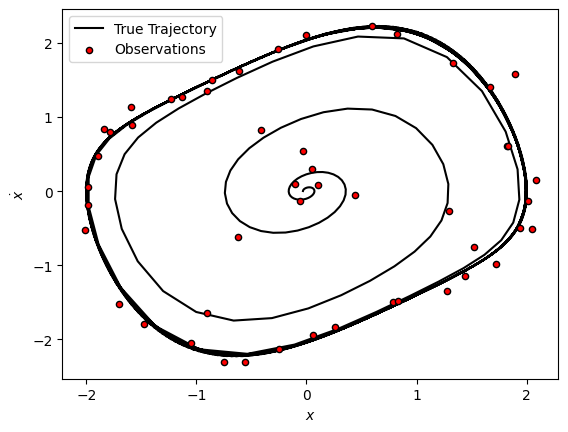

In [4]:
expdata = GenExAdapter(
    system="vdp",
    t0=0.,
    ic_std=0.02,
    t1=2 * t1,
    noise=noise,
    n_train=2 * n_train,
    n_colloc=1000,
    seed=1234
)
true_midpoint = len(expdata.x_true) // 2
train_midpoint = len(expdata.x_train) // 2
x_true = expdata.x_true[:true_midpoint]
t_true = expdata.t_true[:true_midpoint]
t_extend = expdata.t_true[true_midpoint:]
x_true_extend = expdata.x_true[true_midpoint:]
t_colloc = expdata.t_colloc[:true_midpoint]

t_train = expdata.t_train[:train_midpoint]
x_train = expdata.x_train[:train_midpoint]
t_train.shape
print(f"dt_train={t1/n_train}")
print(f"Noise std deviation is {100 * noise / np.std(x_true):.2f}% training data std deviation")
plt.plot(x_true[:,0], x_true[:,1], **TRUE_KW)
plt.xlabel(r"$x$")
plt.ylabel(r"$\dot x$")
plt.scatter(x_train[:,0], x_train[:,1], **OBS_KW)
plt.legend()
None

## Define Model Parameters

In [5]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 0.01))

if not annealing:
    optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e5,
        fixed_data_weight=1,
        sparsifier = sparsifier,
    )
else:
    optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e5,
        fixed_data_weight=1,
        sparsifier = sparsifier,
        num_annealing_steps=4,
    )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

## Fit the model

In [6]:
model.fit(t_train, x_train[:, :1], t_colloc)

print("True model:")
expdata.print()
print("Discovered model:")
model.print()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.12054733e-08, dtype=float64), 'data_weight': 1, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 48.69, gradnorm = 7.068e+03, alpha = 4.167, improvement_ratio = 0.9596
Iteration 1, loss = 1.122, gradnorm = 3.19e+03, alpha = 3.472, improvement_ratio = 0.9892
Iteration 2, loss = 0.5647, gradnorm = 697.5, alpha = 2.894, improvement_ratio = 0.9239
Iteration 3, loss = 0.502, gradnorm = 248.9, alpha = 2.894, improvement_ratio = 0.7811
Iteration 4, loss = 0.4735, gradnorm = 176.7, alpha = 2.411, improvement_ratio = 0.9007
Iteration 5, loss = 0.4641, gradnorm = 78.07, alpha = 2.009, improvement_ratio = 0.9071
Line Search Failed!
Final Iteration Results
Iteration 61, loss = 0.3606, gradnorm = 6.457e-07, alpha = 0.7342, improvement_ratio = -2.488e+03
Model after smooth warm start
(x)'' = -0.011 1 + -1.087 x + 0.479 (x') + -0.008 x^2 + -0.004 x (x') + 0.010 (x')^2 + 0.028 x^3 + -0.320 x^2 (x') + 0.040 x (x')^2 + -0.056 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized
True model:
x' = 1 x'
x'' = -1 x + 0.5 x' + -0.5 x^2 x'
Discovered mo

In [7]:
x_pred = model.predict_state(t_true)
xdot_pred = model.traj_model.derivative(t_true,model.z,diff_order = 1)

def model_ode(t,x,args = None):
    return jnp.array([jnp.array([x[1]]), model.predict(x)]).flatten()

y0 = x_true[-1]

def extend(rhs: Callable, t_extend: jax.Array, y0: jax.Array):
    dt = t_extend[1] - t_extend[0]
    t1 = t_extend[-1]
    t0 = t_extend[0]
    stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
    sol = diffrax.diffeqsolve(
        terms = diffrax.ODETerm(rhs),
        solver = diffrax.Tsit5(),
        t0=t0,
        t1=t1,
        dt0 = dt,
        y0 = y0,
        saveat = diffrax.SaveAt(ts=t_extend),
        stepsize_controller=stepsize_controller,
        max_steps = int(10*(t1-t0)/dt),
    )

    return sol.ys

x_sim = extend(model_ode, t_extend, y0)


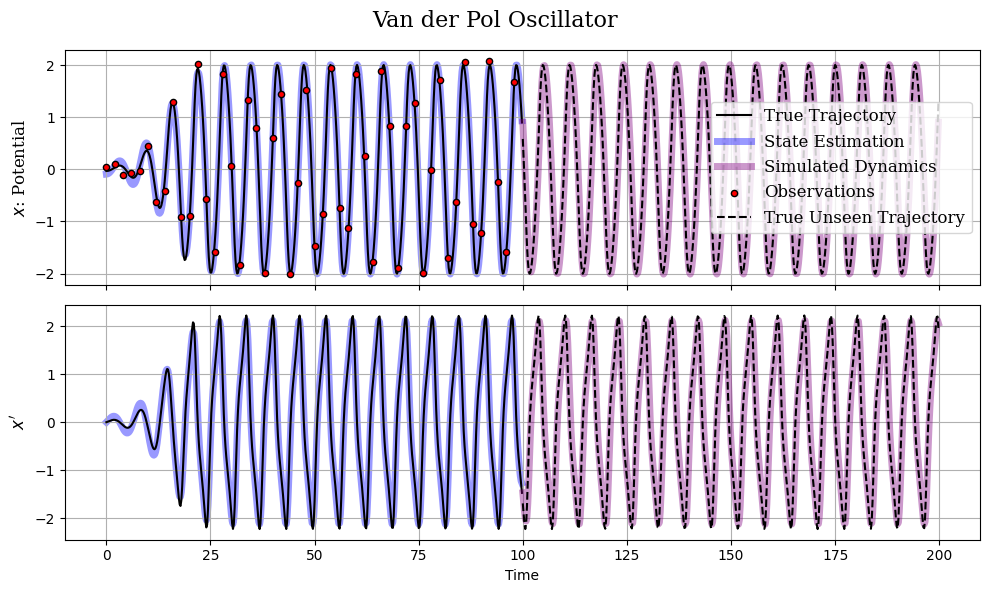

In [8]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], **TRUE_KW)
ax1.plot(t_true, x_pred, **EST_KW)
ax1.plot(t_extend, x_sim[:, 0], **SIM_KW)
ax1.scatter(t_train, x_train[:,0], **OBS_KW)
ax1.plot(t_extend, x_true_extend[:, 0], **TRUE_UNS_KW)

ax1.set_ylabel(r"$x$: Potential", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], **TRUE_KW)
ax2.plot(t_true, xdot_pred, **EST_KW)
ax2.plot(t_extend, x_sim[:, 1], **SIM_KW)
ax2.plot(t_extend, x_true_extend[:, 1], **TRUE_UNS_KW)

ax2.set_ylabel(r"$x'$", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Van der Pol Oscillator", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()